# DataFusionHack

## Introduction

Всем привет, в этом ноутбуке я покажу, как я решал первую задачу, в которой необходимо было классифицировать товары по данным из чека. Данные представляют собой набор размеченных и неразмеченных чеков. Каждый чек имеет такую информацию как описание товара, его категорию, цена товара, количество и пр. Для предсказания категории мы будем пользоваться только описанием товара (item_name). Приятного ресёрча!

In [1]:
# путь до файла
data_train_path = '../data_fusion_train.parquet'

## Importing

Сделаем все необходимые импорты

In [ ]:
!pip install numpy==1.18.5
!pip install pandas==1.1.5
!pip install scikit-learn==0.23.2
!pip install gensim==3.8.3
!pip install xgboost==1.2.1
!pip install nltk==3.2.4

In [2]:
# Data Analysis
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

# Service tools
from tqdm.notebook import tqdm, trange
import logging, sys, os, pickle
from pathlib import Path
tqdm.pandas()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Work with text
import re
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
nltk.download('stopwords')

# Sklearn Pipelines & Preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import *

# Models & Metrics
from sklearn.cluster import KMeans
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# метрика задачи
def score(y_true, y_val):
    return f1_score(y_true, y_val, average='weighted')

# датафрейм, содержащий категорию n
def samples(df, n):
    return df[df.category_id == n]

c:\users\rodion\appdata\local\programs\python\python39\lib\site-packages\tqdm\std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rodion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reading data

Прочитаем данные и сохраним размеченную и неразмеченную части в разных файлах

In [4]:
def read_save(read_path):
    df = pd.read_parquet(read_path)[['item_name', 'category_id']]
    df = df.drop_duplicates('item_name')
    os.makedirs('data', exist_ok=True)
    df[df.category_id == -1]['item_name'].to_csv('data/backup.csv', index=False)
    df[df.category_id != -1].to_csv('data/backup_label.csv', index=False)
    logging.warning('To save RAM restart Notebook and then skip this cell')

df = read_save(data_train_path)

2021-03-22 13:51:19,430 : WARNING : To save RAM restart Notebook and then skip this cell


Теперь посмотрим на данные

In [5]:
df = pd.read_csv('data/backup_label.csv')
df_full = pd.read_csv('data/backup.csv')

for spam_df in [df, df_full]:
    spam_df.dropna(inplace=True)

In [6]:
df_full.sample(10)

,item_name
2437976,Сапоги школьные д/д Flois-Kids (Размер: 34)
882416,Шок.Озера Т/У 100г Молочный /малин шт
2297689,Кальмар в масле Щупальца
1742849,pellesana масло косметическое 100мл
780364,"Обезжириватель Полихим 0,5л шт"
1745151,1 864 055 Обувь весна-лето-осень ABRICOT
1905276,Огурцы Луховицкие Россия 2.456кг*97.00
1159080,Штуцер для шланга VALTEC 3/4 внутр. *20 мм
1733705,"Лизун № ""Роза"""
583559,БЗМЖ Молоко пастеризов 3.7% 1400мл ПЭТ Домик в...


Посмотрим распределение классов

In [7]:
df.category_id.value_counts()

84     7070
71     4760
78     2866
83     2856
0      2352
       ... 
102      19
101      16
46       15
100      14
97       13
Name: category_id, Length: 96, dtype: int64

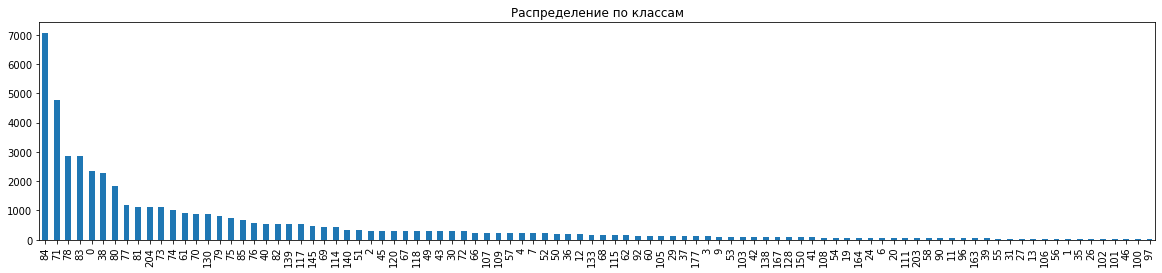

In [8]:
df.category_id.value_counts().plot.bar(figsize=(20, 4))
plt.title('Распределение по классам');

Посмотрим самые частые категории

In [9]:
samples(df, 84).head()

,item_name,category_id
4,Хлеб на СЫВОРОТКЕ 350г,84
5,Сосиска в тесте с сыром 1шт ГЕ,84
13,Курник 1 шт.,84
19,Вафли с топленым молоком вес. 1кг Тортугалия,84
28,Кф.Золотой Степ 50г с орехом,84


In [10]:
samples(df, 71).head()

,item_name,category_id
1,"Компот из изюма, 114 ккал",71
2,"Макаронные изделия отварные (масло сливочное),...",71
15,Филе бедра куриного жареное 3,71
30,МОРС 200 мл,71
41,Kотлета Kуриная Домашняя 100 г,71


## Preprocessing

Препроцессинг включает следующие шаги:
* CamelCase сплиттинг: "СокДобрый" -> "Сок Добрый"
* Нижний регистр
* Транслитерация: "lmnoё" -> "лмное"
* 50x30x45 -> DxDxD
* ["№", "%"] -> ['NUM', 'PERC']
* Замены величин: ["1.5", "1,3 кг" 3,5г -> ["1p5", "1p3кг" "3p5г"]
* сокращения со слешами заменяются: ["ж/б", "тп/р]->["жб", тпр"]
* Не буквы и цифры заменяются на пробелы
* Склейка одиночных символов: "а б в" -> "абв"

In [11]:
# функция для создания словаря транслитераций
def make_trans():
    a = 'a b c d e f g h i j k l m n o p q r s t u v w x y z ё'.split()
    b = 'а в с д е ф г н и ж к л м н о р к р с т у в в х у з е'.split()
    trans_dict = dict(zip(a, b))
    trans_table = ''.join(a).maketrans(trans_dict)
    return trans_table

def normalize(ser: pd.Series):
#   "СокДобрый" -> "Сок Добрый"
    camel_case_pat = re.compile(r'([а-яa-z])([А-ЯA-Z])')
#   "lmno" -> "лмно"
    trans_table = make_trans()
#   "14х15х30" -> "DxDxD"
    dxdxd_pat = re.compile(r'((?:\d+\s*[х\*]\s*){2}\d+)')
#   "1.2 15,5" -> "1p2 15p5"  
    digit_pat = re.compile(r'(\d+)[\.,](\d+)')
#   "15 мл" -> "15мл"
    unit = 'мг|г|гр|кг|мл|л|шт'
    unit_pat = re.compile(fr'((?:\d+p)?\d+)\s*({unit})\b')
#   "ж/б ст/б" -> "жб стб"
    w_w_pat = re.compile(r'\b([а-я]{1,2})/([а-я]{1,2})\b')
#   "a b c d" -> "abcd"
    glue_pat = re.compile(r'(?<=(?<!\w)\w) (?=\w(?!\w))', re.UNICODE)
    
    return ser \
            .str.replace(camel_case_pat, r'\1 \2') \
            .str.lower() \
            .str.replace(r'ъ\b', '') \
            .str.translate(trans_table) \
            .str.replace(dxdxd_pat, ' DxDxD ') \
            .str.replace('№', ' NUM ') \
            .str.replace('%', ' PERC ') \
            .str.replace(digit_pat, r' \1p\2 ') \
            .str.replace(unit_pat, r' \1\2 ') \
            .str.replace(w_w_pat, r' \1\2 ') \
            .str.replace(r'[\W_]', ' ') \
            .str.replace(glue_pat, '')

In [12]:
for spam_df in [df, df_full]:
    spam_df['item_name'] = normalize(spam_df['item_name'])

Посмотрим на результат

In [14]:
df_full.sample(10)

,item_name
2408405,мор эскимо мм 63г
461664,эфес пилснер 0p3
2316442,хек тушка 1кг
344862,капучино бл
1178767,килька черноморская неразделанная в том соусе...
2832448,ментос лимонад 1шт
2710457,саморез универс 4p5 х20 оцинк
51850,фромилид уно таб пролонг дя по плен 500м...
513585,пивной нап амстердам навигатор 6p8 PERC 0...
2446381,семена укроп мамонт 2г


## Fasttext

### Fitting

Для извлечения фичей воспользуемся FastText. Изначально на его месте был Word2Vec, но позже благодаря [@dremovd](https://github.com/dremovd) осознал, что FastText справится здесь лучше. 

Обучать будем на всех неразмеченных данных, чтобы не было лишних утечек. Для начала сделаем сплиттинг строки на список слов, избавившися от однобуквенных слов

In [15]:
df_full.item_name = df_full.item_name.apply(lambda x: [i for i in x.split() if len(i) > 1])

Метод построения векторов (sg), размер вектора (size) и минимальное количество слов в словаре (min_count) были подобраны эмпирическим путём. Стоит отметить, что sg=1 или Skip-Grams mode, когда fasttext (а изначально word2vec) пытается предсказать по слову остальной контент, работает значительно лучше, чем sg=0 или CBOW mode. В качестве аргумента window я поставил максимальную длину списка в корпусе. Для демонстрации я поставил количество эпох (iter) равным 10, хотя оптимальным является 30. Такой bucket выставил для экономии памяти на жёстком диске (и чтобы вместился в сабмит)). Последний параметр workers - это допустимое количество потоков, у меня это число 12. Из-за него кстати нет смысла выставлять seed, так как всё сбивается и воспроизвести решение можно только с workers=1 и seed=КАКОЕ-ТО_ЧИСЛО (конкретно в этой реализации от gensim).

In [ ]:
model = FastText(df_full.item_name, size=200, window=35, min_count=3, workers=12, iter=10, sg=1, bucket=400_000)

Сохраним модель

In [18]:
model.save('ft.model')

2021-03-22 14:05:18,005 : INFO : saving FastText object under ft.model, separately None
2021-03-22 14:05:18,006 : INFO : storing np array 'vectors' to ft.model.wv.vectors.npy
2021-03-22 14:05:18,826 : INFO : storing np array 'vectors_vocab' to ft.model.wv.vectors_vocab.npy
2021-03-22 14:05:19,498 : INFO : storing np array 'vectors_ngrams' to ft.model.wv.vectors_ngrams.npy
2021-03-22 14:05:21,723 : INFO : not storing attribute vectors_norm
2021-03-22 14:05:21,724 : INFO : not storing attribute vectors_vocab_norm
2021-03-22 14:05:21,724 : INFO : not storing attribute vectors_ngrams_norm
2021-03-22 14:05:21,725 : INFO : not storing attribute buckets_word
2021-03-22 14:05:21,726 : INFO : storing np array 'syn1neg' to ft.model.trainables.syn1neg.npy
2021-03-22 14:05:22,500 : INFO : storing np array 'vectors_vocab_lockf' to ft.model.trainables.vectors_vocab_lockf.npy
2021-03-22 14:05:23,187 : INFO : storing np array 'vectors_ngrams_lockf' to ft.model.trainables.vectors_ngrams_lockf.npy
2021-

### Model optimization

Больше всего в fasttext отнимается памяти из-за ngram, на данный момент модель занимает 1Гб (!) на жёстком диске. С этим надо было как-то бороться и первое что пришло в голову: заменить float32, в котором хранятся вектора на float16. Это сожмёт нашу модель как минимум в 2 раза. Можете убедиться: это не повлияет на качество классификатора

Посмотрим на файлы, относящиеся к FastText

In [19]:
list(map(str,Path('.').glob('*.npy')))

['ft.model.trainables.syn1neg.npy',
 'ft.model.trainables.vectors_ngrams_lockf.npy',
 'ft.model.trainables.vectors_vocab_lockf.npy',
 'ft.model.wv.vectors.npy',
 'ft.model.wv.vectors_ngrams.npy',
 'ft.model.wv.vectors_vocab.npy']

In [20]:
for file in map(str,Path('.').glob('*.npy')):
    logging.info(file)
    spam = np.load(file)
    logging.info(f'min/max values before: {spam.min(), spam.max()}')
    spam = spam.astype('float16')
    logging.info(f'min/max values after: {spam.min(), spam.max()}')
    with open(file, 'wb') as f:
        np.save(f, spam)
    logging.info('__________________________________')

2021-03-22 14:05:26,489 : INFO : ft.model.trainables.syn1neg.npy
2021-03-22 14:05:26,565 : INFO : min/max values before: (-2.090169, 2.0418446)
2021-03-22 14:05:27,033 : INFO : min/max values after: (-2.09, 2.041)
2021-03-22 14:05:27,322 : INFO : __________________________________
2021-03-22 14:05:27,323 : INFO : ft.model.trainables.vectors_ngrams_lockf.npy
2021-03-22 14:05:27,500 : INFO : min/max values before: (1.0, 1.0)
2021-03-22 14:05:28,249 : INFO : min/max values after: (1.0, 1.0)
2021-03-22 14:05:29,133 : INFO : __________________________________
2021-03-22 14:05:29,134 : INFO : ft.model.trainables.vectors_vocab_lockf.npy
2021-03-22 14:05:29,220 : INFO : min/max values before: (1.0, 1.0)
2021-03-22 14:05:29,518 : INFO : min/max values after: (1.0, 1.0)
2021-03-22 14:05:29,820 : INFO : __________________________________
2021-03-22 14:05:29,820 : INFO : ft.model.wv.vectors.npy
2021-03-22 14:05:29,899 : INFO : min/max values before: (-2.720382, 2.59036)
2021-03-22 14:05:30,374 : I

После этих манипуляций файлы занимают 500Мб. Но этого всё-равно недостаточно: надо будет как-то уместить классификатор

Видим, что у нас есть файлы целиком состоящие из единичек (минимальное и максимальное значения - это единицы). Взглянем на них разок

In [21]:
spam = np.load('ft.model.trainables.vectors_ngrams_lockf.npy')

In [22]:
spam

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float16)

In [23]:
spam.shape

(400000, 200)

Ого, вы видели, сколько эта вещь занимает в памяти?! К счастью, архиваторы умеют грамотно сжимать такие файлы из повторяющихся элементов, так что можем быть уверены, что в итоге у нас останется память для классификатора

### Vector averaging

Извлечём фичи. Для этого получим вектора каждого слова из предложения, сложим их и отнормируем его, чтобы его размер был равен 1. 

In [24]:
model = FastText.load('ft.model')

2021-03-22 14:05:41,479 : INFO : loading FastText object from ft.model
2021-03-22 14:05:41,690 : INFO : loading wv recursively from ft.model.wv.* with mmap=None
2021-03-22 14:05:41,691 : INFO : loading vectors from ft.model.wv.vectors.npy with mmap=None
2021-03-22 14:05:41,724 : INFO : loading vectors_vocab from ft.model.wv.vectors_vocab.npy with mmap=None
2021-03-22 14:05:41,760 : INFO : loading vectors_ngrams from ft.model.wv.vectors_ngrams.npy with mmap=None
2021-03-22 14:05:41,857 : INFO : setting ignored attribute vectors_norm to None
2021-03-22 14:05:41,857 : INFO : setting ignored attribute vectors_vocab_norm to None
2021-03-22 14:05:41,858 : INFO : setting ignored attribute vectors_ngrams_norm to None
2021-03-22 14:05:41,859 : INFO : setting ignored attribute buckets_word to None
2021-03-22 14:05:41,859 : INFO : loading vocabulary recursively from ft.model.vocabulary.* with mmap=None
2021-03-22 14:05:41,860 : INFO : loading trainables recursively from ft.model.trainables.* with

In [25]:
def word_averaging(wv, words):
    mean = np.zeros((wv.vector_size,))
    
    for word in words:
        mean += wv.get_vector(word)

    mean = gensim.matutils.unitvec(mean)
    return mean

def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list])

Также для ускорения алгоритмов классификации приведём полученную матрицу к типу float16

In [31]:
df.item_name = df.item_name.apply(lambda x: [i for i in x.split() if len(i) > 1])
X_wv = word_averaging_list(model.wv, df.item_name)
X_wv = X_wv.astype('float16')

y = df.category_id

Огромный плюс fasttext'а в том, что он может векторизовать слова, даже которых нет в словаре, благодаря ngram'ам

## Classification

Наконец-то перейдём к классификации. Будем использовать модель SVM для классификации. Она показала здесь лучшее качество. Также не забудем отнормировать данные перед подачей в классификатор: сделаем пайплайн

In [32]:
pipe = make_pipeline(
    StandardScaler(),
    SVC(random_state=0),
)

In [33]:
%%time
cross_val_score(pipe, 
                X_wv, 
                y, 
                scoring='f1_weighted',
                cv=StratifiedKFold(5, 
                                   shuffle=True, 
                                   random_state=0), 
                n_jobs=5
)

Wall time: 5min 56s


array([0.86135208, 0.85232645, 0.85836571, 0.85216471, 0.86253755])

Итак, получили неплохое качество на крос-валидации. Обучим на всех данных и сохраним модель

In [ ]:
pipe.fit(X_wv, y)
pickle.dump(pipe, open(f'clf_task1', 'wb'))

## Conclusion

На тесте данное решение получило 0.865. Особую благодарность хотелось бы выразить [@dremovd](https://github.com/dremovd), с которым мы были в одной команде. Он направлял меня в нужную сторону, и без него мы бы не вышли в топ-10.

Спасибо за ресёрч данного ноутбука, в нём я привёл в краткой форме решение задачи. Ждите более расширенного решения с анализом ошибок, стакингом и постпроцессингом :) 

До новых встреч!